In [ ]:
import pandas as pd
import re
import nltk
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import matplotlib.pyplot as plt

In [84]:
data = pd.read_csv('preprocessed_posts.csv')

In [85]:
data

,caption,caption_norm,nama_tempat,jam_operasional,alamat,kota,akun_instagram,open_time,close_time,is_24h,is_overnight,menu_category,function_category
0,Seriussn waktu itu pas lewat kirain gedung nik...,seriussn waktu itu pas lewat kirain gedung nik...,Lyon’s Cafe & Coworking Space,24 Jam,"Jl. Nyi Tjondrolukito No 82, Kutu Dukuh, Sindu...",Sleman,@lyonscafe.co,00:00,23:59,True,False,['kopi'],['wfc']
1,Seriusan coffee shop baru 24 jam dari Bandung ...,seriusan coffee shop baru 24 jam dari bandung ...,Beri Kopi Jogja,24 Jam,"Dero, Condongcatur, Sleman, Yogyakarta",Sleman,@berikopi.jogja,00:00,23:59,True,False,"['kopi', 'makanan']","['wfc', 'hangout', 'dating']"
2,Baru di Jogja - Artisan bakery & coffee esteti...,baru di jogja - artisan bakery coffee estetik ...,Elder On The Table - EOTB,07:00 - 22:00,"Jl. Kranggan, Jetis, Yogyakarta",Yogyakarta,"@elder.onthetable, @elderpatisserie",07:00,22:00,False,False,"['kopi', 'dessert']",['dating']
3,Cold ‘N Brew baru aja buka cabangnya di Maliob...,cold n brew baru aja buka cabangnya di maliobo...,Seperti cabang lainnya,24 Jam,"Jl. Mataram, Yogyakarta",Yogyakarta,@coldnbrew,00:00,23:59,True,False,[],['wfc']
4,Baru lagi di Jogja! Coffee & dining artistik a...,baru lagi di jogja coffee dining artistik aest...,Waktu Luang De Loji,10:00 - 22:00,"Jl. Panembahan Senopati, Prawirodirjan, Kec. G...",Yogyakarta,@waktuluang.deloji,10:00,22:00,False,False,['makanan'],['dating']
...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,"Lunaria, coffee and eatery estetik baru di Ged...","lunaria, coffee and eatery estetik baru di ged...",Lunaria Coffee,08:00 - 22:00,Jl. Gedongkiwo No.29 (Pojok Beteng Kulon),Lainnya,@lunariacoffee,08:00,22:00,False,False,"['kopi', 'makanan']","['wfc', 'hangout']"
372,"Kolokial Coffee, coffee shop bertema medieval ...","kolokial coffee, coffee shop bertema medieval ...",Kolokial Coffee,09:00-22.00,"Jl. Affandi No.30, Condongcatur, Depok, Kabupa...",Sleman,@kolokial.coffeeyk,09:00,22:00,False,False,['makanan'],['hangout']
373,Merindu bersama di Ruang Rindu Coffee\n\nCoffe...,merindu bersama di ruang rindu coffee\ncoffee ...,Ruang Rindu Coffee,08:00 - 01:00,"Jl. Perumnas, Kledokan, Caturtunggal, Depok, S...",Sleman,@kopiruangrindu,08:00,01:00,False,True,"['kopi', 'makanan']","['wfc', 'hangout', 'dating']"
374,"Kastem Space Gantara, penyegaran coffee shop d...","kastem space gantara, penyegaran coffee shop d...",Kasteman Space Gantara,10:00 - 24.00,"Jl. Lowanu, Sorosutan, Umbulharjo, Kota Yogyak...",Yogyakarta,@kastemspace_gantara,10:00,23:59,False,False,['kopi'],['wfc']


In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   caption            376 non-null    object
 1   caption_norm       376 non-null    object
 2   nama_tempat        375 non-null    object
 3   jam_operasional    376 non-null    object
 4   alamat             376 non-null    object
 5   kota               376 non-null    object
 6   akun_instagram     370 non-null    object
 7   open_time          376 non-null    object
 8   close_time         376 non-null    object
 9   is_24h             376 non-null    bool  
 10  is_overnight       376 non-null    bool  
 11  menu_category      376 non-null    object
 12  function_category  376 non-null    object
dtypes: bool(2), object(11)
memory usage: 33.2+ KB


# Cleaning Data

In [87]:
spam_keywords = [
    'filano', 'yamaha', 'giveaway'
]

def is_spam(text):
    if pd.isna(text):
        return True
    t = text.lower()
    if sum(1 for kw in spam_keywords if kw in t) >= 2:
        return True
    if len(re.findall(r'@\w+', t)) > 3:
        return True
    if len(re.findall(r'#\w+', t)) > 10:
        return True
    return False

data["is_spam"] = data["caption"].apply(is_spam)
data = data[~data["is_spam"]].reset_index(drop=True)

In [88]:
# Hitung jumlah data
print(f"Jumlah data setelah menghapus spam: {len(data)}")

Jumlah data setelah menghapus spam: 336


In [89]:
def normalize_caption_post(text):
    if pd.isna(text):
        return None
    text = text.lower()
    text = re.sub(r"[—–−]+", "-", text)
    # Remove hastag
    text = re.sub(r"#\w+", "", text)
    # Remove mentions
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[\U00010000-\U0010FFFF]", "", text)
    return text

In [90]:
def clean_caption_text_from_row(row):
    caption = normalize_caption_post(row["caption"])
    nama_tempat = str(row.get("nama_tempat","")).lower()
    jam_buka = str(row.get("jam_buka","")).lower()
    alamat = str(row.get("alamat","")).lower()

    if pd.isna(caption):
        return None

    lines = [l.strip() for l in caption.split("\n") if l.strip()]
    cleaned_lines = []

    for line in lines:
        low = line.lower()

        if nama_tempat and nama_tempat in low:
            continue
        if jam_buka and jam_buka in low:
            continue
        if alamat and alamat in low:
            continue

        line = re.sub(r"@\w+", "", line)
        line = re.sub(r"#\w+", "", line)
        line = re.sub(r"[^a-z\s]", " ", line)
        line = re.sub(r"\s+", " ", line).strip()

        if line:
            cleaned_lines.append(line)

    return " ".join(cleaned_lines) if cleaned_lines else None

data["clean_caption_raw"] = data.apply(clean_caption_text_from_row, axis=1)

In [91]:
factory = StopWordRemoverFactory()


stopwords = set(factory.get_stop_words())

additional_stopwords = {
    "yg","aja","nih","sih","dong","banget","bikin",
    "jadi","udah","cuma","kayak","gitu","deh",
    "lah","pun","kan","ya","ga","gak","nggak",
    "nya","dan","yang","untuk","dengan","karena", "buat",
    "luas", "coffee", "tempat", "tempatnya", "menu", "menunya",
    "shop", "coffee", "cafe", "kalian", "kamu",
    "banyak", "cukup", "beberapa", "jogja", "jalan",
    "kemarin","pengen","temen","suka","baru","langsung","satu", "area",
    "sama","pas","bener","kalau","punya","ternyata","sangat",
    "mau","hingga","bagian","tengah","masuk","satu","baru",
    "langsung","cocok","pilihan","bakal","dateng","salah","lebih","iya","coba",
    "depan", "buka", "lantai", "lewat", "nyobain", "seturan",
    "lalu", "promo", "mulai", "ngga", "sekitar", "sekali",
    'tau','nih','siap','nih','loh','wih','woi','hayo',
    'semi', "nah", "jam", "kali", "jauh", "mungkin", "sekalian",
    "belakang", "cek", "sekarang", "menarik", 
    "menemukan", "terakhir", 'suasana', "slide", "ngga",
    "kopi", "konsep", "menikmati", "datang", "daerah",
    "nyaman", "menjadi"
}
stopwords = stopwords.union(additional_stopwords)

def preprocess_for_lda(text):
    if pd.isna(text):
        return ""
    tokens = [t for t in text.split() if t not in stopwords and len(t) > 2]
    return " ".join(tokens)

data["clean_text_lda"] = data["clean_caption_raw"].apply(preprocess_for_lda)

# LDA

In [92]:
vectorizer = CountVectorizer(max_df=0.85, min_df=5, ngram_range=(1,1))
X = vectorizer.fit_transform(data["clean_text_lda"])

In [93]:
n_topics = 4
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X)

LatentDirichletAllocation(n_components=4, random_state=42)

In [94]:
feature_names = vectorizer.get_feature_names_out()
print("\n================ LDA TOPIC KEYWORDS ================\n")
for topic_idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-6:-1]]
    print(f"Topik {topic_idx}: {' | '.join(top_words)}")


================ LDA TOPIC KEYWORDS ================

Topik 0: mocktail | unik | susu | makanan | sore
Topik 1: ngopi | pohon | kota | enak | makan
Topik 2: indoor | outdoor | room | lengkap | view
Topik 3: nugas | bar | indoor | duduk | outdoor


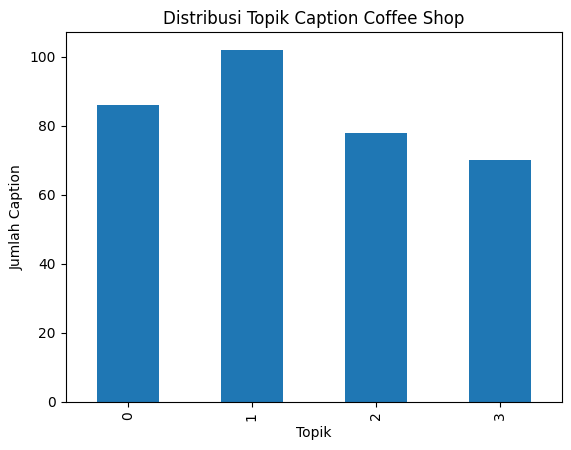

In [95]:
topic_distribution = lda.transform(X)
data["dominant_topic"] = topic_distribution.argmax(axis=1)

topic_cols = [f"topic_{i}" for i in range(n_topics)]
topic_df = pd.DataFrame(topic_distribution, columns=topic_cols)
data = pd.concat([data, topic_df], axis=1)

data["dominant_topic"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribusi Topik Caption Coffee Shop")
plt.xlabel("Topik")
plt.ylabel("Jumlah Caption")
plt.show()

In [96]:
# Jumlah data per topik
topic_counts = data["dominant_topic"].value_counts().sort_index()
print("\n================ TOPIC COUNTS ================\n")
for topic_idx, count in topic_counts.items():
    print(f"Topik {topic_idx}: {count} postingan")


================ TOPIC COUNTS ================

Topik 0: 86 postingan
Topik 1: 102 postingan
Topik 2: 78 postingan
Topik 3: 70 postingan


In [97]:
print("\n================ SAMPLE RESULT ================\n")
print(data[["clean_text_lda","dominant_topic"]].head(10))


================ SAMPLE RESULT ================

                                      clean_text_lda  dominant_topic
0  seriussn waktu kirain gedung nikahan bangunann...               1
1  seriusan bandung asik bangett asik gagal susun...               1
2  artisan bakery estetik lucu kranggan akhir tah...               1
3  cold brew cabangnya malioboro bangunannya park...               2
4  dining artistik aesthetic deket titik nol siap...               1
5  nyulap rumah indis bangunan tua super aestheti...               0
6  siapa deket sanata dharma cake secakep selucu ...               2
7  malioboro stasiun tugu ngopi makan pastry enak...               1
8  seruu ngopi pagi ngemil jajan pasar enjoy vibe...               2
9  seneng ngopi roastery milih pakai beans apa mi...               1


In [112]:
# Tampilan probabilitas topik untuk 5 data pertama
print(data[topic_cols].head(5))

    topic_0   topic_1   topic_2   topic_3
0  0.010230  0.572510  0.010475  0.406785
1  0.008524  0.656936  0.325856  0.008684
2  0.006547  0.980786  0.006253  0.006413
3  0.013353  0.014111  0.958498  0.014039
4  0.007156  0.978595  0.007175  0.007074


In [98]:
# Cek skor coherence dan perplexity
perplexity = lda.perplexity(X)  

print(f"Perplexity Score: {perplexity}\n")

Perplexity Score: 690.4459726047005



In [99]:
topic_labels = {
    0: "Menu Variatif",
    1: "Ngopi Santai",
    2: "Area Lengkap",
    3: "WFC Nyaman"
}

data["Kategori Tempat"] = data["dominant_topic"].map(topic_labels)


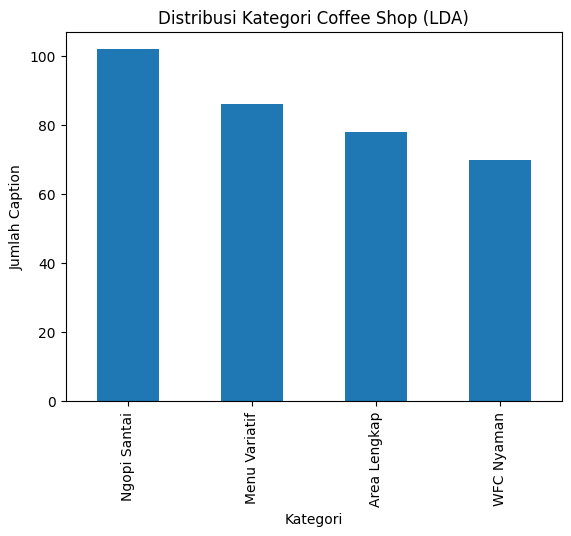


================ SAMPLE RESULT ================



,clean_text_lda,Kategori Tempat,Kategori Multilabel Str
0,seriussn waktu kirain gedung nikahan bangunann...,Ngopi Santai,"Ngopi Santai, WFC Nyaman"
1,seriusan bandung asik bangett asik gagal susun...,Ngopi Santai,"Ngopi Santai, Area Lengkap"
2,artisan bakery estetik lucu kranggan akhir tah...,Ngopi Santai,Ngopi Santai
3,cold brew cabangnya malioboro bangunannya park...,Area Lengkap,Area Lengkap
4,dining artistik aesthetic deket titik nol siap...,Ngopi Santai,Ngopi Santai
5,nyulap rumah indis bangunan tua super aestheti...,Menu Variatif,"Menu Variatif, Area Lengkap"
6,siapa deket sanata dharma cake secakep selucu ...,Area Lengkap,Area Lengkap
7,malioboro stasiun tugu ngopi makan pastry enak...,Ngopi Santai,Ngopi Santai
8,seruu ngopi pagi ngemil jajan pasar enjoy vibe...,Area Lengkap,"Ngopi Santai, Area Lengkap"
9,seneng ngopi roastery milih pakai beans apa mi...,Ngopi Santai,Ngopi Santai


In [100]:
threshold = 0.20

def get_multilabel_topics(probs, threshold=0.20):
    labels = [i for i, p in enumerate(probs) if p >= threshold]
    if not labels:
        labels = [int(np.argmax(probs))]
    return labels

data["topic_multilabel"] = [
    get_multilabel_topics(probs, threshold)
    for probs in topic_distribution
]

data["Kategori Multilabel"] = data["topic_multilabel"].apply(
    lambda topics: [topic_labels[t] for t in topics]
)

data["Kategori Multilabel Str"] = data["Kategori Multilabel"].apply(
    lambda lst: ", ".join(lst)
)

data["Kategori Tempat"].value_counts().plot(kind="bar")
plt.title("Distribusi Kategori Coffee Shop (LDA)")
plt.xlabel("Kategori")
plt.ylabel("Jumlah Caption")
plt.show()


print("\n================ SAMPLE RESULT ================\n")
data[[
    "clean_text_lda",
    "Kategori Tempat",
    "Kategori Multilabel Str"
]].head(10)

In [101]:
data

,caption,caption_norm,nama_tempat,jam_operasional,alamat,kota,akun_instagram,open_time,close_time,is_24h,...,clean_text_lda,dominant_topic,topic_0,topic_1,topic_2,topic_3,Kategori Tempat,topic_multilabel,Kategori Multilabel,Kategori Multilabel Str
0,Seriussn waktu itu pas lewat kirain gedung nik...,seriussn waktu itu pas lewat kirain gedung nik...,Lyon’s Cafe & Coworking Space,24 Jam,"Jl. Nyi Tjondrolukito No 82, Kutu Dukuh, Sindu...",Sleman,@lyonscafe.co,00:00,23:59,True,...,seriussn waktu kirain gedung nikahan bangunann...,1,0.010230,0.572510,0.010475,0.406785,Ngopi Santai,"[1, 3]","[Ngopi Santai, WFC Nyaman]","Ngopi Santai, WFC Nyaman"
1,Seriusan coffee shop baru 24 jam dari Bandung ...,seriusan coffee shop baru 24 jam dari bandung ...,Beri Kopi Jogja,24 Jam,"Dero, Condongcatur, Sleman, Yogyakarta",Sleman,@berikopi.jogja,00:00,23:59,True,...,seriusan bandung asik bangett asik gagal susun...,1,0.008524,0.656936,0.325856,0.008684,Ngopi Santai,"[1, 2]","[Ngopi Santai, Area Lengkap]","Ngopi Santai, Area Lengkap"
2,Baru di Jogja - Artisan bakery & coffee esteti...,baru di jogja - artisan bakery coffee estetik ...,Elder On The Table - EOTB,07:00 - 22:00,"Jl. Kranggan, Jetis, Yogyakarta",Yogyakarta,"@elder.onthetable, @elderpatisserie",07:00,22:00,False,...,artisan bakery estetik lucu kranggan akhir tah...,1,0.006547,0.980786,0.006253,0.006413,Ngopi Santai,[1],[Ngopi Santai],Ngopi Santai
3,Cold ‘N Brew baru aja buka cabangnya di Maliob...,cold n brew baru aja buka cabangnya di maliobo...,Seperti cabang lainnya,24 Jam,"Jl. Mataram, Yogyakarta",Yogyakarta,@coldnbrew,00:00,23:59,True,...,cold brew cabangnya malioboro bangunannya park...,2,0.013353,0.014111,0.958498,0.014039,Area Lengkap,[2],[Area Lengkap],Area Lengkap
4,Baru lagi di Jogja! Coffee & dining artistik a...,baru lagi di jogja coffee dining artistik aest...,Waktu Luang De Loji,10:00 - 22:00,"Jl. Panembahan Senopati, Prawirodirjan, Kec. G...",Yogyakarta,@waktuluang.deloji,10:00,22:00,False,...,dining artistik aesthetic deket titik nol siap...,1,0.007156,0.978595,0.007175,0.007074,Ngopi Santai,[1],[Ngopi Santai],Ngopi Santai
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,"Lunaria, coffee and eatery estetik baru di Ged...","lunaria, coffee and eatery estetik baru di ged...",Lunaria Coffee,08:00 - 22:00,Jl. Gedongkiwo No.29 (Pojok Beteng Kulon),Lainnya,@lunariacoffee,08:00,22:00,False,...,lunaria and eatery estetik gedongkiwo bangunan...,3,0.416848,0.002787,0.087897,0.492467,WFC Nyaman,"[0, 3]","[Menu Variatif, WFC Nyaman]","Menu Variatif, WFC Nyaman"
332,"Kolokial Coffee, coffee shop bertema medieval ...","kolokial coffee, coffee shop bertema medieval ...",Kolokial Coffee,09:00-22.00,"Jl. Affandi No.30, Condongcatur, Depok, Kabupa...",Sleman,@kolokial.coffeeyk,09:00,22:00,False,...,membuat penasaran sejak proses pembangunannya ...,0,0.714529,0.015298,0.015593,0.254579,Menu Variatif,"[0, 3]","[Menu Variatif, WFC Nyaman]","Menu Variatif, WFC Nyaman"
333,Merindu bersama di Ruang Rindu Coffee\n\nCoffe...,merindu bersama di ruang rindu coffee\ncoffee ...,Ruang Rindu Coffee,08:00 - 01:00,"Jl. Perumnas, Kledokan, Caturtunggal, Depok, S...",Sleman,@kopiruangrindu,08:00,01:00,False,...,letaknya perumnas ngasih pengalaman berbeda la...,3,0.307470,0.004033,0.003997,0.684500,WFC Nyaman,"[0, 3]","[Menu Variatif, WFC Nyaman]","Menu Variatif, WFC Nyaman"
334,"Kastem Space Gantara, penyegaran coffee shop d...","kastem space gantara, penyegaran coffee shop d...",Kasteman Space Gantara,10:00 - 24.00,"Jl. Lowanu, Sorosutan, Umbulharjo, Kota Yogyak...",Yogyakarta,@kastemspace_gantara,10:00,23:59,False,...,kastem space gantara penyegaran selatan sukses...,0,0.879821,0.109360,0.005452,0.005366,Menu Variatif,[0],[Menu Variatif],Menu Variatif


In [102]:
final_data = data[[
    "caption", 'nama_tempat', 'alamat', 'jam_operasional', 'kota', 'akun_instagram', 'open_time', 'close_time',
    'is_24h', 'is_overnight', 'Kategori Tempat', 'Kategori Multilabel', 'Kategori Multilabel Str']]

# Ganti nama kolom agar konsisten
final_data = final_data.rename(columns={
    'jam_operasional': 'Jam Operasional',
    'akun_instagram': 'Akun Instagram',
    'is_24h': 'Is 24H',
    'is_overnight': 'Is Overnight',
    'nama_tempat': 'Nama Tempat',
    'alamat': 'Alamat',
    'kota': 'Kota',
    'open_time': 'Jam Buka',
    'close_time': 'Jam Tutup',
    'Kategori Tempat': 'Kategori Tempat',
    'Kategori Multilabel': 'Kategori Multilabel List',
    'Kategori Multilabel Str': 'Kategori Multilabel'
})

final_data

,caption,Nama Tempat,Alamat,Jam Operasional,Kota,Akun Instagram,Jam Buka,Jam Tutup,Is 24H,Is Overnight,Kategori Tempat,Kategori Multilabel List,Kategori Multilabel
0,Seriussn waktu itu pas lewat kirain gedung nik...,Lyon’s Cafe & Coworking Space,"Jl. Nyi Tjondrolukito No 82, Kutu Dukuh, Sindu...",24 Jam,Sleman,@lyonscafe.co,00:00,23:59,True,False,Ngopi Santai,"[Ngopi Santai, WFC Nyaman]","Ngopi Santai, WFC Nyaman"
1,Seriusan coffee shop baru 24 jam dari Bandung ...,Beri Kopi Jogja,"Dero, Condongcatur, Sleman, Yogyakarta",24 Jam,Sleman,@berikopi.jogja,00:00,23:59,True,False,Ngopi Santai,"[Ngopi Santai, Area Lengkap]","Ngopi Santai, Area Lengkap"
2,Baru di Jogja - Artisan bakery & coffee esteti...,Elder On The Table - EOTB,"Jl. Kranggan, Jetis, Yogyakarta",07:00 - 22:00,Yogyakarta,"@elder.onthetable, @elderpatisserie",07:00,22:00,False,False,Ngopi Santai,[Ngopi Santai],Ngopi Santai
3,Cold ‘N Brew baru aja buka cabangnya di Maliob...,Seperti cabang lainnya,"Jl. Mataram, Yogyakarta",24 Jam,Yogyakarta,@coldnbrew,00:00,23:59,True,False,Area Lengkap,[Area Lengkap],Area Lengkap
4,Baru lagi di Jogja! Coffee & dining artistik a...,Waktu Luang De Loji,"Jl. Panembahan Senopati, Prawirodirjan, Kec. G...",10:00 - 22:00,Yogyakarta,@waktuluang.deloji,10:00,22:00,False,False,Ngopi Santai,[Ngopi Santai],Ngopi Santai
...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,"Lunaria, coffee and eatery estetik baru di Ged...",Lunaria Coffee,Jl. Gedongkiwo No.29 (Pojok Beteng Kulon),08:00 - 22:00,Lainnya,@lunariacoffee,08:00,22:00,False,False,WFC Nyaman,"[Menu Variatif, WFC Nyaman]","Menu Variatif, WFC Nyaman"
332,"Kolokial Coffee, coffee shop bertema medieval ...",Kolokial Coffee,"Jl. Affandi No.30, Condongcatur, Depok, Kabupa...",09:00-22.00,Sleman,@kolokial.coffeeyk,09:00,22:00,False,False,Menu Variatif,"[Menu Variatif, WFC Nyaman]","Menu Variatif, WFC Nyaman"
333,Merindu bersama di Ruang Rindu Coffee\n\nCoffe...,Ruang Rindu Coffee,"Jl. Perumnas, Kledokan, Caturtunggal, Depok, S...",08:00 - 01:00,Sleman,@kopiruangrindu,08:00,01:00,False,True,WFC Nyaman,"[Menu Variatif, WFC Nyaman]","Menu Variatif, WFC Nyaman"
334,"Kastem Space Gantara, penyegaran coffee shop d...",Kasteman Space Gantara,"Jl. Lowanu, Sorosutan, Umbulharjo, Kota Yogyak...",10:00 - 24.00,Yogyakarta,@kastemspace_gantara,10:00,23:59,False,False,Menu Variatif,[Menu Variatif],Menu Variatif


In [103]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   caption                   336 non-null    object
 1   Nama Tempat               335 non-null    object
 2   Alamat                    336 non-null    object
 3   Jam Operasional           336 non-null    object
 4   Kota                      336 non-null    object
 5   Akun Instagram            330 non-null    object
 6   Jam Buka                  336 non-null    object
 7   Jam Tutup                 336 non-null    object
 8   Is 24H                    336 non-null    bool  
 9   Is Overnight              336 non-null    bool  
 10  Kategori Tempat           336 non-null    object
 11  Kategori Multilabel List  336 non-null    object
 12  Kategori Multilabel       336 non-null    object
dtypes: bool(2), object(11)
memory usage: 29.7+ KB


In [104]:
# Baris dengan Akun Instagram duplikat
duplicate_instagram = final_data[final_data.duplicated(subset=['Akun Instagram'], keep=False)]
duplicate_instagram['Akun Instagram']

3                            @coldnbrew
7                                   NaN
11                           @coldnbrew
16                        @filosofikopi
17                        @filosofikopi
20                      @koatcoffee.idn
22                                  NaN
23                @cultureheadsignature
31               @kanarisocietyandspace
43                         @ruminate.id
55                          @rekaya.idn
69                @lestaricorner.coffee
75                 @anakpanahbizz.jogja
79                      @koatcoffee.idn
99                                  NaN
105                       @teraskemarin
113                       @kopine.eyang
114    @inikopiulon, @inikopiulon.sagan
134                       @gurugiristay
135                         @azencoffee
137                           @westpash
138    @inikopiulon, @inikopiulon.sagan
141                    @omahdhuwurjogja
143                    @omahdhuwurjogja
144                           @westpash


In [105]:
# Drop duplicate subset Akun Instagram
final_data = final_data.drop_duplicates(subset=['Akun Instagram'], keep='first').reset_index(drop=True)

In [106]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   caption                   309 non-null    object
 1   Nama Tempat               308 non-null    object
 2   Alamat                    309 non-null    object
 3   Jam Operasional           309 non-null    object
 4   Kota                      309 non-null    object
 5   Akun Instagram            308 non-null    object
 6   Jam Buka                  309 non-null    object
 7   Jam Tutup                 309 non-null    object
 8   Is 24H                    309 non-null    bool  
 9   Is Overnight              309 non-null    bool  
 10  Kategori Tempat           309 non-null    object
 11  Kategori Multilabel List  309 non-null    object
 12  Kategori Multilabel       309 non-null    object
dtypes: bool(2), object(11)
memory usage: 27.3+ KB


In [107]:
# Save ke CSV
final_data.to_csv('lda_categorized_posts.csv', index=False)

In [108]:
h

NameError: name 'h' is not defined